# Multi-task Learning
> Training 5 models on census data taking salary and marital status as proxies for CTR and CTCVR proxy. Objective is to learn about different models and how they work.

- toc: true
- badges: true
- comments: true
- categories: [MultiTaskLearning, MultiTask]
- author: "<a href='https://github.com/morningsky/multi_task_learning'>Sky</a>"
- image:

## Setup

In [ ]:
!pip install deepctr[cpu]

In [ ]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test

In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score

import tensorflow as tf

from deepctr.feature_column import build_input_features, input_from_feature_columns
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names

from deepctr.layers.core import PredictionLayer, DNN
from deepctr.layers.utils import combined_dnn_input 

import warnings
warnings.filterwarnings('ignore')

## Tasks

| Task | Goal | Proxy |
| - | -:| ---:|
| Task 1 | Predict whether the income exceeds 50K | ctr |
| Task 2 | Predict whether this person’s marital status is never married | ctcvr |

## Data

In [11]:
CENSUS_COLUMNS = ['age','workclass','fnlwgt','education','education_num',
                  'marital_status','occupation','relationship','race','gender',
                  'capital_gain','capital_loss','hours_per_week','native_country',
                  'income_bracket']

df_train = pd.read_csv('adult.data',header=None,names=CENSUS_COLUMNS)
df_test = pd.read_csv('adult.test',header=None,names=CENSUS_COLUMNS)

data = pd.concat([df_train, df_test], axis=0)

#take task1 as ctr task, take task2 as ctcvr task.
data['ctr_label'] = data['income_bracket'].map({' >50K.':1, ' >50K':1, ' <=50K.':0, ' <=50K':0})
data['ctcvr_label'] = data['marital_status'].apply(lambda x: 1 if x==' Never-married' else 0)
data.drop(labels=['marital_status', 'income_bracket'], axis=1, inplace=True)

## Features

In [12]:
#define dense and sparse features
columns = data.columns.values.tolist()
dense_features = ['fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
sparse_features = [col for col in columns if col not in dense_features and col not in ['ctr_label', 'ctcvr_label']]

data[sparse_features] = data[sparse_features].fillna('-1', )
data[dense_features] = data[dense_features].fillna(0, )
mms = MinMaxScaler(feature_range=(0, 1))
data[dense_features] = mms.fit_transform(data[dense_features])
    
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])
    
fixlen_feature_columns = [SparseFeat(feat, data[feat].max()+1, embedding_dim=16)for feat in sparse_features] \
+ [DenseFeat(feat, 1,) for feat in dense_features]

dnn_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(dnn_feature_columns)

## Train & Test Data

In [14]:
#train test split
n_train = df_train.shape[0]
train = data[:n_train]
test = data[n_train:]
train_model_input = {name: train[name] for name in feature_names}
test_model_input = {name: test[name] for name in feature_names}

## Models

### Shared Bottom

[Multitask Learning (1998)](http://reports-archive.adm.cs.cmu.edu/anon/1997/CMU-CS-97-203.pdf)

Rich Caruana


**Abstract**: 

*Multitask Learning is an approach to inductive transfer that improves learning for one task by using the information contained in the training signals of other related tasks. It does this by learning tasks in parallel while using a shared representation; what is learned for each task can help other tasks be learned better. In this thesis we demonstrate multitask learning for a dozen problems. We explain how multitask learning works and show that there are many opportunities for multitask learning in real domains. We show that in some cases features that would normally be used as inputs work better if used as multitask outputs instead. We present suggestions for how to get the most out of multitask learning in articial neural nets, present an algorithm for multitask learning with case-based methods like k-nearest neighbor and kernel regression, and sketch an algorithm for multitask learning in decision trees. Multitask learning improves generalization performance, can be applied in many dierent kinds of domains, and can be used with dierent learning algorithms. We conjecture there will be many opportunities for its use on real-world problems.*

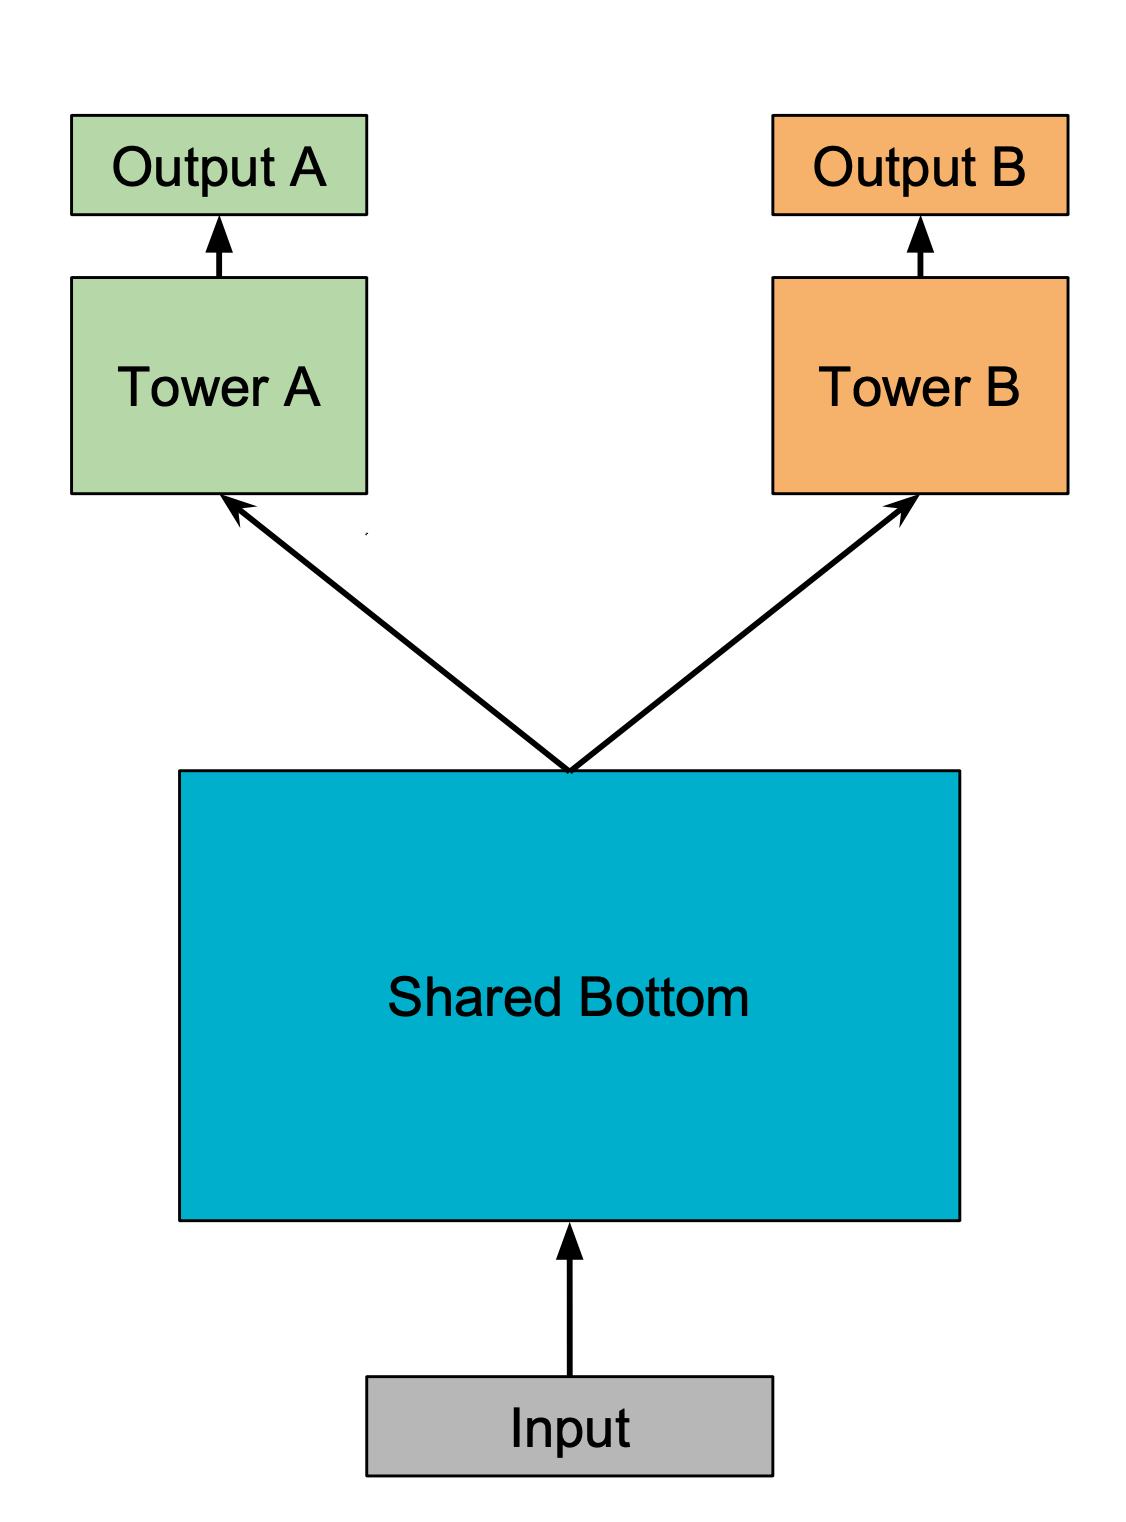

In [5]:
# import tensorflow as tf

# from deepctr.feature_column import build_input_features, input_from_feature_columns
# from deepctr.layers.core import PredictionLayer, DNN
# from deepctr.layers.utils import combined_dnn_input 

def Shared_Bottom(dnn_feature_columns, num_tasks, task_types, task_names,
                  bottom_dnn_units=[128, 128], tower_dnn_units_lists=[[64,32], [64,32]],
                  l2_reg_embedding=0.00001, l2_reg_dnn=0, seed=1024, dnn_dropout=0,
                 dnn_activation='relu', dnn_use_bn=False):
    """Instantiates the Shared_Bottom multi-task learning Network architecture.
    
    :param dnn_feature_columns: An iterable containing all the features used by deep part of the model.
    :param num_tasks:  integer, number of tasks, equal to number of outputs, must be greater than 1.
    :param task_types: list of str, indicating the loss of each tasks, ``"binary"`` for  binary logloss or  ``"regression"`` for regression loss. e.g. ['binary', 'regression']
    :param task_names: list of str, indicating the predict target of each tasks
    :param bottom_dnn_units: list,list of positive integer or empty list, the layer number and units in each layer of shared-bottom DNN
    :param tower_dnn_units_lists: list, list of positive integer list, its length must be euqal to num_tasks, the layer number and units in each layer of task-specific DNN
    :param l2_reg_embedding: float. L2 regularizer strength applied to embedding vector
    :param l2_reg_dnn: float. L2 regularizer strength applied to DNN
    :param seed: integer ,to use as random seed.
    :param dnn_dropout: float in [0,1), the probability we will drop out a given DNN coordinate.
    :param dnn_activation: Activation function to use in DNN
    :param dnn_use_bn: bool. Whether use BatchNormalization before activation or not in DNN
    :return: A Keras model instance.
    """
    if num_tasks <= 1:
        raise ValueError("num_tasks must be greater than 1")
    if len(task_types) != num_tasks:
        raise ValueError("num_tasks must be equal to the length of task_types")
        
    for task_type in task_types:
        if task_type not in ['binary', 'regression']:
            raise ValueError("task must be binary or regression, {} is illegal".format(task_type))
            
    if num_tasks != len(tower_dnn_units_lists):
        raise ValueError("the length of tower_dnn_units_lists must be euqal to num_tasks")

    features = build_input_features(dnn_feature_columns)
    inputs_list = list(features.values())
    
    sparse_embedding_list, dense_value_list = input_from_feature_columns(features, dnn_feature_columns, l2_reg_embedding,seed)

    dnn_input = combined_dnn_input(sparse_embedding_list, dense_value_list)
    shared_bottom_output = DNN(bottom_dnn_units, dnn_activation, l2_reg_dnn, dnn_dropout, dnn_use_bn, seed=seed)(dnn_input)

    tasks_output = []
    for task_type, task_name, tower_dnn in zip(task_types, task_names, tower_dnn_units_lists):
        tower_output = DNN(tower_dnn, dnn_activation, l2_reg_dnn, dnn_dropout, dnn_use_bn, seed=seed, name='tower_'+task_name)(shared_bottom_output)
        
        logit = tf.keras.layers.Dense(1, use_bias=False, activation=None)(tower_output)
        output = PredictionLayer(task_type, name=task_name)(logit) #regression->keep, binary classification->sigmoid
        tasks_output.append(output)

    model = tf.keras.models.Model(inputs=inputs_list, outputs=tasks_output)
    return model

### ESSM

[Entire Space Multi-Task Model: An Effective Approach for Estimating Post-Click Conversion Rate (SIGIR'18)](https://arxiv.org/abs/1804.07931)

Xiao Ma, Liqin Zhao, Guan Huang, Zhi Wang, Zelin Hu, Xiaoqiang Zhu, Kun Gai


**Abstract**: 

*Estimating post-click conversion rate (CVR) accurately is crucial for ranking systems in industrial applications such as recommendation and advertising. Conventional CVR modeling applies popular deep learning methods and achieves state-of-the-art performance. However it encounters several task-specific problems in practice, making CVR modeling challenging. For example, conventional CVR models are trained with samples of clicked impressions while utilized to make inference on the entire space with samples of all impressions. This causes a sample selection bias problem. Besides, there exists an extreme data sparsity problem, making the model fitting rather difficult. In this paper, we model CVR in a brand-new perspective by making good use of sequential pattern of user actions, i.e., impression -> click -> conversion. The proposed Entire Space Multi-task Model (ESMM) can eliminate the two problems simultaneously by i) modeling CVR directly over the entire space, ii) employing a feature representation transfer learning strategy. Experiments on dataset gathered from Taobao's recommender system demonstrate that ESMM significantly outperforms competitive methods. We also release a sampling version of this dataset to enable future research. To the best of our knowledge, this is the first public dataset which contains samples with sequential dependence of click and conversion labels for CVR modeling.*

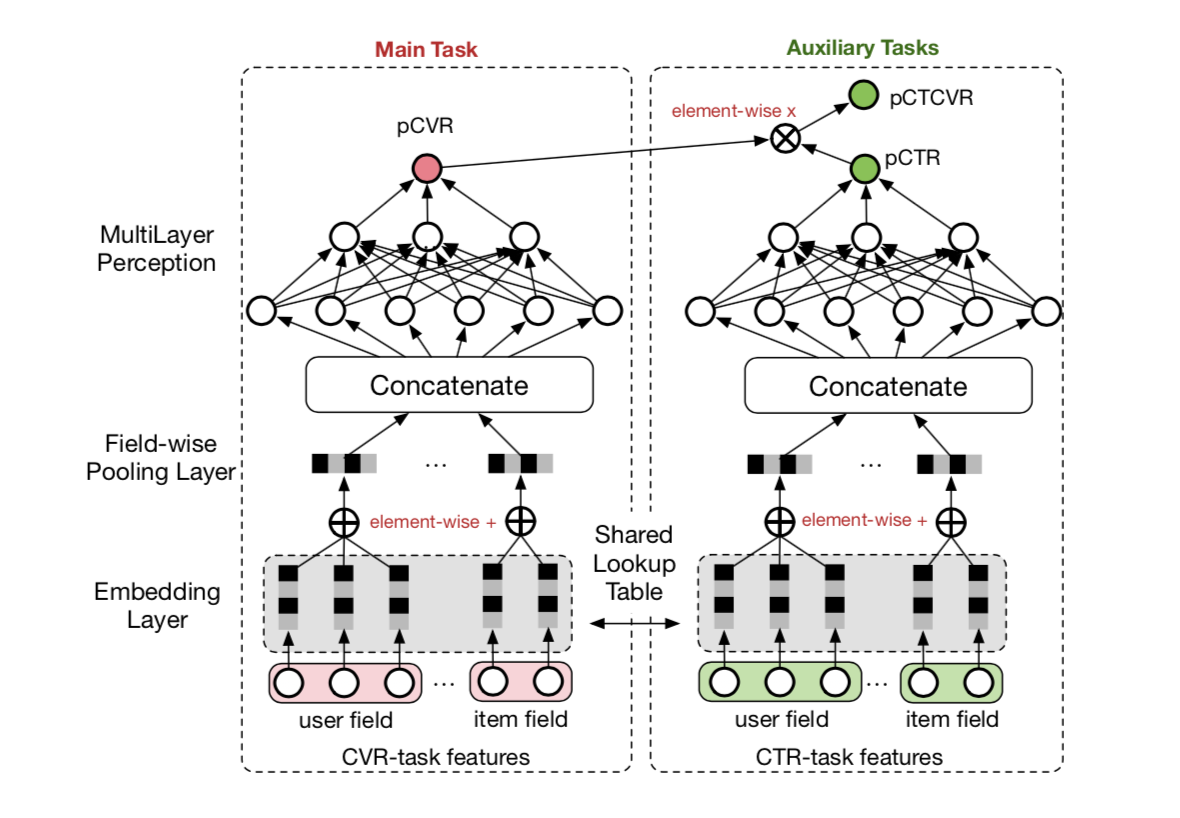

In [6]:
# import tensorflow as tf

# from deepctr.feature_column import build_input_features, input_from_feature_columns
# from deepctr.layers.core import PredictionLayer, DNN
# from deepctr.layers.utils import combined_dnn_input 


def ESSM(dnn_feature_columns, task_type='binary', task_names=['ctr', 'ctcvr'],
        tower_dnn_units_lists=[[128, 128],[128, 128]], l2_reg_embedding=0.00001, l2_reg_dnn=0, 
         seed=1024, dnn_dropout=0,dnn_activation='relu', dnn_use_bn=False):
    """Instantiates the Entire Space Multi-Task Model architecture.
    
    :param dnn_feature_columns: An iterable containing all the features used by deep part of the model.
    :param task_type:  str, indicating the loss of each tasks, ``"binary"`` for  binary logloss or  ``"regression"`` for regression loss.
    :param task_names: list of str, indicating the predict target of each tasks. default value is ['ctr', 'ctcvr']
    :param tower_dnn_units_lists: list, list of positive integer, the length must be equal to 2, the layer number and units in each layer of task-specific DNN
    :param l2_reg_embedding: float. L2 regularizer strength applied to embedding vector
    :param l2_reg_dnn: float. L2 regularizer strength applied to DNN
    :param seed: integer ,to use as random seed.
    :param dnn_dropout: float in [0,1), the probability we will drop out a given DNN coordinate.
    :param dnn_activation: Activation function to use in DNN
    :param dnn_use_bn: bool. Whether use BatchNormalization before activation or not in DNN
    :return: A Keras model instance.
    """
    if len(task_names)!=2:
        raise ValueError("the length of task_names must be equal to 2")
    
    if len(tower_dnn_units_lists)!=2:
        raise ValueError("the length of tower_dnn_units_lists must be equal to 2")

    features = build_input_features(dnn_feature_columns)
    inputs_list = list(features.values())
    
    sparse_embedding_list, dense_value_list = input_from_feature_columns(features, dnn_feature_columns, l2_reg_embedding,seed)

    dnn_input = combined_dnn_input(sparse_embedding_list, dense_value_list)
    
    ctr_output = DNN(tower_dnn_units_lists[0], dnn_activation, l2_reg_dnn, dnn_dropout, dnn_use_bn, seed=seed)(dnn_input)
    cvr_output = DNN(tower_dnn_units_lists[1], dnn_activation, l2_reg_dnn, dnn_dropout, dnn_use_bn, seed=seed)(dnn_input)
    
    ctr_logit = tf.keras.layers.Dense(1, use_bias=False, activation=None)(ctr_output)
    cvr_logit = tf.keras.layers.Dense(1, use_bias=False, activation=None)(cvr_output)
    
    ctr_pred = PredictionLayer(task_type, name=task_names[0])(ctr_logit) 
    cvr_pred = PredictionLayer(task_type)(cvr_logit) 
    
    ctcvr_pred = tf.keras.layers.Multiply(name=task_names[1])([ctr_pred, cvr_pred]) #CTCVR = CTR * CVR

    model = tf.keras.models.Model(inputs=inputs_list, outputs=[ctr_pred, ctcvr_pred])    
    return model

### MMoE

[Modeling Task Relationships in Multi-task Learning with Multi-gate Mixture-of-Experts (KDD'18)](https://dl.acm.org/doi/abs/10.1145/3219819.3220007)

Jiaqi Ma, Zhe Zhao, Xinyang Yi, Jilin Chen, Lichan Hong, Ed H. Chi


**Abstract**: 

*Neural-based multi-task learning has been successfully used in many real-world large-scale applications such as recommendation systems. For example, in movie recommendations, beyond providing users movies which they tend to purchase and watch, the system might also optimize for users liking the movies afterwards. With multi-task learning, we aim to build a single model that learns these multiple goals and tasks simultaneously. However, the prediction quality of commonly used multi-task models is often sensitive to the relationships between tasks. It is therefore important to study the modeling tradeoffs between task-specific objectives and inter-task relationships. In this work, we propose a novel multi-task learning approach, Multi-gate Mixture-of-Experts (MMoE), which explicitly learns to model task relationships from data. We adapt the Mixture-of-Experts (MoE) structure to multi-task learning by sharing the expert submodels across all tasks, while also having a gating network trained to optimize each task. To validate our approach on data with different levels of task relatedness, we first apply it to a synthetic dataset where we control the task relatedness. We show that the proposed approach performs better than baseline methods when the tasks are less related. We also show that the MMoE structure results in an additional trainability benefit, depending on different levels of randomness in the training data and model initialization. Furthermore, we demonstrate the performance improvements by MMoE on real tasks including a binary classification benchmark, and a large-scale content recommendation system at Google.*

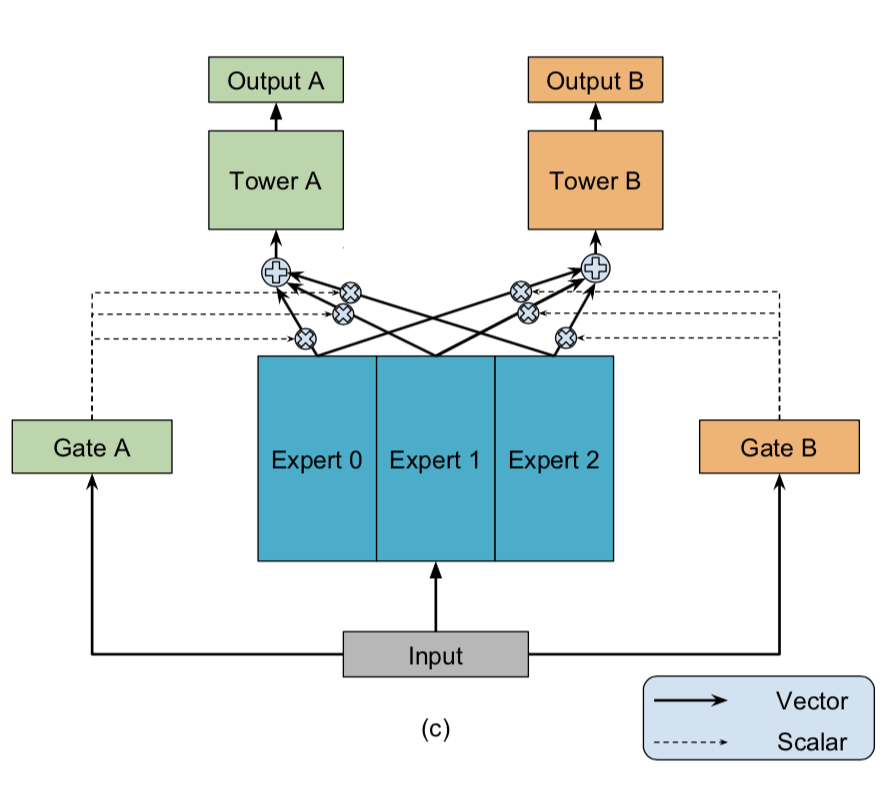

In [7]:
# import tensorflow as tf

# from deepctr.feature_column import build_input_features, input_from_feature_columns
# from deepctr.layers.core import PredictionLayer, DNN
# from deepctr.layers.utils import combined_dnn_input

def MMOE(dnn_feature_columns, num_tasks, task_types, task_names, num_experts=4, 
          expert_dnn_units=[32,32],  gate_dnn_units=[16,16], tower_dnn_units_lists=[[16,8],[16,8]],
          l2_reg_embedding=1e-5, l2_reg_dnn=0, seed=1024, dnn_dropout=0, dnn_activation='relu', dnn_use_bn=False):
    """Instantiates the Multi-gate Mixture-of-Experts multi-task learning architecture.
    
    :param dnn_feature_columns: An iterable containing all the features used by deep part of the model.
    :param num_tasks: integer, number of tasks, equal to number of outputs, must be greater than 1.
    :param task_types: list of str, indicating the loss of each tasks, ``"binary"`` for  binary logloss, ``"regression"`` for regression loss. e.g. ['binary', 'regression']
    :param task_names: list of str, indicating the predict target of each tasks
    
    :param num_experts: integer, number of experts.
    :param expert_dnn_units: list, list of positive integer, its length must be greater than 1, the layer number and units in each layer of expert DNN
    :param gate_dnn_units: list, list of positive integer, its length must be greater than 1, the layer number and units in each layer of gate DNN
    :param tower_dnn_units_lists: list, list of positive integer list, its length must be euqal to num_tasks, the layer number and units in each layer of task-specific DNN
    
    :param l2_reg_embedding: float. L2 regularizer strength applied to embedding vector
    :param l2_reg_dnn: float. L2 regularizer strength applied to DNN
    :param seed: integer ,to use as random seed.
    :param dnn_dropout: float in [0,1), the probability we will drop out a given DNN coordinate.
    :param dnn_activation: Activation function to use in DNN
    :param dnn_use_bn: bool. Whether use BatchNormalization before activation or not in DNN
    :return: a Keras model instance
    """
    
    if num_tasks <= 1:
        raise ValueError("num_tasks must be greater than 1")
    if len(task_types) != num_tasks:
        raise ValueError("num_tasks must be equal to the length of task_types")
        
    for task_type in task_types:
        if task_type not in ['binary', 'regression']:
            raise ValueError("task must be binary or regression, {} is illegal".format(task_type))
            
    if num_tasks != len(tower_dnn_units_lists):
        raise ValueError("the length of tower_dnn_units_lists must be euqal to num_tasks")

    features = build_input_features(dnn_feature_columns)

    inputs_list = list(features.values())

    sparse_embedding_list, dense_value_list = input_from_feature_columns(features, dnn_feature_columns,
                                                                         l2_reg_embedding, seed)
    dnn_input = combined_dnn_input(sparse_embedding_list, dense_value_list)
    
    #build expert layer
    expert_outs = []
    for i in range(num_experts):
        expert_network = DNN(expert_dnn_units, dnn_activation, l2_reg_dnn, dnn_dropout, dnn_use_bn, seed=seed, name='expert_'+str(i))(dnn_input)
        expert_outs.append(expert_network)
    expert_concat = tf.keras.layers.concatenate(expert_outs, axis=1, name='expert_concat')
    expert_concat = tf.keras.layers.Reshape([num_experts, expert_dnn_units[-1]], name='expert_reshape')(expert_concat) #(num_experts, output dim of expert_network)

    mmoe_outs = []
    for i in range(num_tasks): #one mmoe layer: nums_tasks = num_gates
        #build gate layers
        gate_network = DNN(gate_dnn_units, dnn_activation, l2_reg_dnn, dnn_dropout, dnn_use_bn, seed=seed, name='gate_'+task_names[i])(dnn_input)
        gate_out = tf.keras.layers.Dense(num_experts, use_bias=False, activation='softmax', name='gate_softmax_'+task_names[i])(gate_network)
        gate_out = tf.tile(tf.expand_dims(gate_out, axis=-1), [1, 1, expert_dnn_units[-1]]) #let the shape of gate_out be (num_experts, output dim of expert_network)

        #gate multiply the expert
        gate_mul_expert = tf.keras.layers.Multiply(name='gate_mul_expert_'+task_names[i])([expert_concat, gate_out]) 
        gate_mul_expert = tf.math.reduce_sum(gate_mul_expert, axis=1) #sum pooling in the expert ndim
        mmoe_outs.append(gate_mul_expert)
    
    task_outs = []
    for task_type, task_name, tower_dnn, mmoe_out in zip(task_types, task_names, tower_dnn_units_lists, mmoe_outs):
        #build tower layer
        tower_output = DNN(tower_dnn, dnn_activation, l2_reg_dnn, dnn_dropout, dnn_use_bn, seed=seed, name='tower_'+task_name)(mmoe_out)
        
        logit = tf.keras.layers.Dense(1, use_bias=False, activation=None)(tower_output)
        output = PredictionLayer(task_type, name=task_name)(logit) 
        task_outs.append(output)
        
    model = tf.keras.models.Model(inputs=inputs_list, outputs=task_outs)
    return model

### CGC

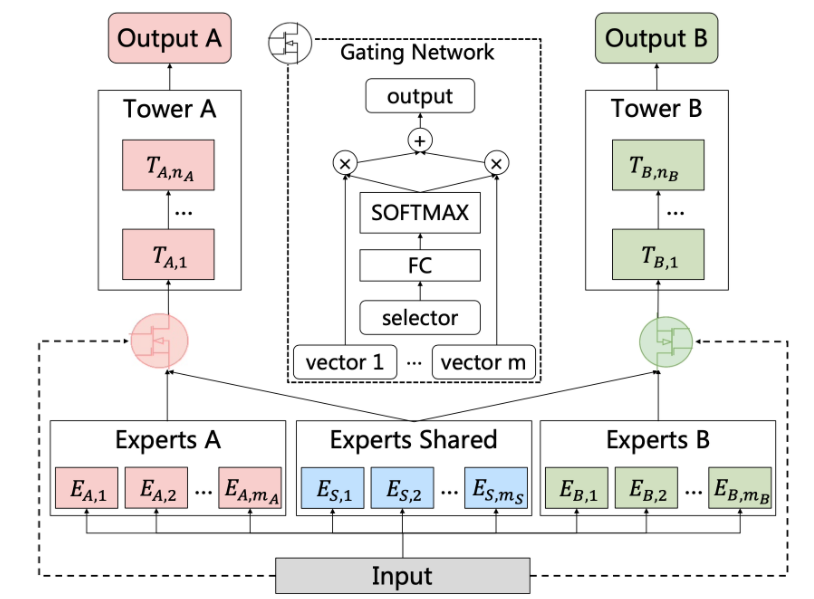

In [8]:
# import tensorflow as tf

# from deepctr.feature_column import build_input_features, input_from_feature_columns
# from deepctr.layers.core import PredictionLayer, DNN
# from deepctr.layers.utils import combined_dnn_input 

def PLE_CGC(dnn_feature_columns, num_tasks, task_types, task_names, num_experts_specific=8, num_experts_shared=4,
          expert_dnn_units=[64,64],  gate_dnn_units=[16,16], tower_dnn_units_lists=[[16,16],[16,16]],
          l2_reg_embedding=1e-5, l2_reg_dnn=0, seed=1024, dnn_dropout=0, dnn_activation='relu', dnn_use_bn=False):
    """Instantiates the Customized Gate Control block of Progressive Layered Extraction architecture.
    
    :param dnn_feature_columns: An iterable containing all the features used by deep part of the model.
    :param num_tasks: integer, number of tasks, equal to number of outputs, must be greater than 1.
    :param task_types: list of str, indicating the loss of each tasks, ``"binary"`` for  binary logloss, ``"regression"`` for regression loss. e.g. ['binary', 'regression']
    :param task_names: list of str, indicating the predict target of each tasks
    
    :param num_experts_specific: integer, number of task-specific experts.
    :param num_experts_shared: integer, number of task-shared experts.
    :param expert_dnn_units: list, list of positive integer, its length must be greater than 1, the layer number and units in each layer of expert DNN
    :param gate_dnn_units: list, list of positive integer, its length must be greater than 1, the layer number and units in each layer of gate DNN
    :param tower_dnn_units_lists: list, list of positive integer list, its length must be euqal to num_tasks, the layer number and units in each layer of task-specific DNN
    
    :param l2_reg_embedding: float. L2 regularizer strength applied to embedding vector
    :param l2_reg_dnn: float. L2 regularizer strength applied to DNN
    :param seed: integer ,to use as random seed.
    :param dnn_dropout: float in [0,1), the probability we will drop out a given DNN coordinate.
    :param dnn_activation: Activation function to use in DNN
    :param dnn_use_bn: bool. Whether use BatchNormalization before activation or not in DNN
    :return: a Keras model instance
    """
    
    if num_tasks <= 1:
        raise ValueError("num_tasks must be greater than 1")
    if len(task_types) != num_tasks:
        raise ValueError("num_tasks must be equal to the length of task_types")
        
    for task_type in task_types:
        if task_type not in ['binary', 'regression']:
            raise ValueError("task must be binary or regression, {} is illegal".format(task_type))
            
    if num_tasks != len(tower_dnn_units_lists):
        raise ValueError("the length of tower_dnn_units_lists must be euqal to num_tasks")

    features = build_input_features(dnn_feature_columns)

    inputs_list = list(features.values())

    sparse_embedding_list, dense_value_list = input_from_feature_columns(features, dnn_feature_columns,
                                                                         l2_reg_embedding, seed)
    dnn_input = combined_dnn_input(sparse_embedding_list, dense_value_list)
    
    expert_outputs = []
    #build task-specific expert layer
    for i in range(num_tasks):
        for j in range(num_experts_specific):
            expert_network = DNN(expert_dnn_units, dnn_activation, l2_reg_dnn, dnn_dropout, dnn_use_bn, seed=seed, name='task_'+task_names[i]+'_expert_specific_'+str(j))(dnn_input)
            expert_outputs.append(expert_network)

    #build task-shared expert layer
    for i in range(num_experts_shared):
        expert_network = DNN(expert_dnn_units, dnn_activation, l2_reg_dnn, dnn_dropout, dnn_use_bn, seed=seed, name='expert_shared_'+str(i))(dnn_input)
        expert_outputs.append(expert_network)
        


    cgc_outs = []
    for i in range(num_tasks): 
        #concat task-specific expert and task-shared expert
        cur_expert_num = num_experts_specific + num_experts_shared
        cur_experts = expert_outputs[i * num_experts_specific:(i + 1) * num_experts_specific] + expert_outputs[-int(num_experts_shared):] #task_specific + task_shared
        expert_concat = tf.keras.layers.concatenate(cur_experts, axis=1, name='expert_concat_'+task_names[i])
        expert_concat = tf.keras.layers.Reshape([cur_expert_num, expert_dnn_units[-1]], name='expert_reshape_'+task_names[i])(expert_concat)
        
        #build gate layers
        gate_network = DNN(gate_dnn_units, dnn_activation, l2_reg_dnn, dnn_dropout, dnn_use_bn, seed=seed, name='gate_'+task_names[i])(dnn_input)
        gate_out = tf.keras.layers.Dense(cur_expert_num, use_bias=False, activation='softmax', name='gate_softmax_'+task_names[i])(gate_network)
        gate_out = tf.tile(tf.expand_dims(gate_out, axis=-1), [1, 1, expert_dnn_units[-1]]) 
        
        #gate multiply the expert
        gate_mul_expert = tf.keras.layers.Multiply(name='gate_mul_expert_'+task_names[i])([expert_concat, gate_out]) 
        gate_mul_expert = tf.math.reduce_sum(gate_mul_expert, axis=1) #sum pooling in the expert ndim
        cgc_outs.append(gate_mul_expert)
    
    task_outs = []
    for task_type, task_name, tower_dnn, cgc_out in zip(task_types, task_names, tower_dnn_units_lists, cgc_outs):
        #build tower layer
        tower_output = DNN(tower_dnn, dnn_activation, l2_reg_dnn, dnn_dropout, dnn_use_bn, seed=seed, name='tower_'+task_name)(cgc_out)
        logit = tf.keras.layers.Dense(1, use_bias=False, activation=None)(tower_output)
        output = PredictionLayer(task_type, name=task_name)(logit) 
        task_outs.append(output)
        
    model = tf.keras.models.Model(inputs=inputs_list, outputs=task_outs)
    return model

### PLE

[Progressive Layered Extraction (PLE): A Novel Multi-Task Learning (MTL) Model for Personalized Recommendations (RecSys'20)](https://dl.acm.org/doi/10.1145/3383313.3412236)

Hongyan Tang, Junning Liu, Ming Zhao, Xudong Gong


**Abstract**: 

*Multi-task learning (MTL) has been successfully applied to many recommendation applications. However, MTL models often suffer from performance degeneration with negative transfer due to the complex and competing task correlation in real-world recommender systems. Moreover, through extensive experiments across SOTA MTL models, we have observed an interesting seesaw phenomenon that performance of one task is often improved by hurting the performance of some other tasks. To address these issues, we propose a Progressive Layered Extraction (PLE) model with a novel sharing structure design. PLE separates shared components and task-specific components explicitly and adopts a progressive routing mechanism to extract and separate deeper semantic knowledge gradually, improving efficiency of joint representation learning and information routing across tasks in a general setup. We apply PLE to both complicatedly correlated and normally correlated tasks, ranging from two-task cases to multi-task cases on a real-world Tencent video recommendation dataset with 1 billion samples, and results show that PLE outperforms state-of-the-art MTL models significantly under different task correlations and task-group size. Furthermore, online evaluation of PLE on a large-scale content recommendation platform at Tencent manifests 2.23% increase in view-count and 1.84% increase in watch time compared to SOTA MTL models, which is a significant improvement and demonstrates the effectiveness of PLE. Finally, extensive offline experiments on public benchmark datasets demonstrate that PLE can be applied to a variety of scenarios besides recommendations to eliminate the seesaw phenomenon. PLE now has been deployed to the online video recommender system in Tencent successfully.*

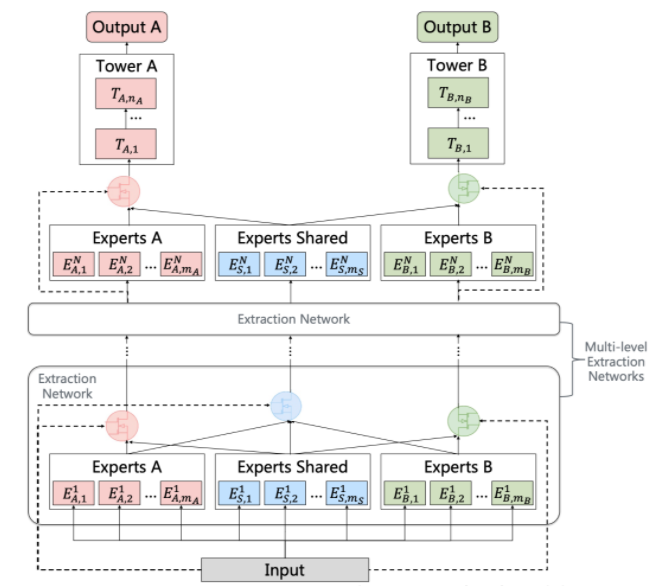

In [9]:
# import tensorflow as tf

# from deepctr.feature_column import build_input_features, input_from_feature_columns
# from deepctr.layers.core import PredictionLayer, DNN
# from deepctr.layers.utils import combined_dnn_input 

def PLE(dnn_feature_columns, num_tasks, task_types, task_names, num_levels=1, num_experts_specific=8, num_experts_shared=4,
          expert_dnn_units=[64,64],  gate_dnn_units=[16,16], tower_dnn_units_lists=[[16,16],[16,16]],
          l2_reg_embedding=1e-5, l2_reg_dnn=0, seed=1024, dnn_dropout=0, dnn_activation='relu', dnn_use_bn=False):
    """Instantiates the multi level of Customized Gate Control of Progressive Layered Extraction architecture.
    
    :param dnn_feature_columns: An iterable containing all the features used by deep part of the model.
    :param num_tasks: integer, number of tasks, equal to number of outputs, must be greater than 1.
    :param task_types: list of str, indicating the loss of each tasks, ``"binary"`` for  binary logloss, ``"regression"`` for regression loss. e.g. ['binary', 'regression']
    :param task_names: list of str, indicating the predict target of each tasks
    
    :param num_levels: integer, number of CGC levels.
    :param num_experts_specific: integer, number of task-specific experts.
    :param num_experts_shared: integer, number of task-shared experts.
    :param expert_dnn_units: list, list of positive integer, its length must be greater than 1, the layer number and units in each layer of expert DNN
    :param gate_dnn_units: list, list of positive integer, its length must be greater than 1, the layer number and units in each layer of gate DNN
    :param tower_dnn_units_lists: list, list of positive integer list, its length must be euqal to num_tasks, the layer number and units in each layer of task-specific DNN
    
    :param l2_reg_embedding: float. L2 regularizer strength applied to embedding vector
    :param l2_reg_dnn: float. L2 regularizer strength applied to DNN
    :param seed: integer ,to use as random seed.
    :param dnn_dropout: float in [0,1), the probability we will drop out a given DNN coordinate.
    :param dnn_activation: Activation function to use in DNN
    :param dnn_use_bn: bool. Whether use BatchNormalization before activation or not in DNN
    :return: a Keras model instance
    """
    
    if num_tasks <= 1:
        raise ValueError("num_tasks must be greater than 1")
    if len(task_types) != num_tasks:
        raise ValueError("num_tasks must be equal to the length of task_types")
        
    for task_type in task_types:
        if task_type not in ['binary', 'regression']:
            raise ValueError("task must be binary or regression, {} is illegal".format(task_type))
            
    if num_tasks != len(tower_dnn_units_lists):
        raise ValueError("the length of tower_dnn_units_lists must be euqal to num_tasks")

    features = build_input_features(dnn_feature_columns)

    inputs_list = list(features.values())

    sparse_embedding_list, dense_value_list = input_from_feature_columns(features, dnn_feature_columns,
                                                                         l2_reg_embedding, seed)
    dnn_input = combined_dnn_input(sparse_embedding_list, dense_value_list)
 
    #single cgc layer
    def cgc_net(inputs, level_name, is_last=False):
        #inputs: [task1, task2, ... taskn, shared task]
        
        expert_outputs = []
        #build task-specific expert layer
        for i in range(num_tasks):
            for j in range(num_experts_specific):
                expert_network = DNN(expert_dnn_units, dnn_activation, l2_reg_dnn, dnn_dropout, dnn_use_bn, seed=seed, name=level_name+'task_'+task_names[i]+'_expert_specific_'+str(j))(inputs[i])
                expert_outputs.append(expert_network)

        #build task-shared expert layer
        for i in range(num_experts_shared):
            expert_network = DNN(expert_dnn_units, dnn_activation, l2_reg_dnn, dnn_dropout, dnn_use_bn, seed=seed, name=level_name+'expert_shared_'+str(i))(inputs[-1]) 
            expert_outputs.append(expert_network)

        #task_specific gate (count = num_tasks)
        cgc_outs = []
        for i in range(num_tasks): 
            #concat task-specific expert and task-shared expert
            cur_expert_num = num_experts_specific + num_experts_shared
            cur_experts = expert_outputs[i * num_experts_specific:(i + 1) * num_experts_specific] + expert_outputs[-int(num_experts_shared):] #task_specific + task_shared
            
            expert_concat = tf.keras.layers.concatenate(cur_experts, axis=1, name=level_name+'expert_concat_specific_'+task_names[i])
            expert_concat = tf.keras.layers.Reshape([cur_expert_num, expert_dnn_units[-1]], name=level_name+'expert_reshape_specific_'+task_names[i])(expert_concat)

            #build gate layers
            gate_network = DNN(gate_dnn_units, dnn_activation, l2_reg_dnn, dnn_dropout, dnn_use_bn, seed=seed, name=level_name+'gate_specific_'+task_names[i])(inputs[i]) #gate[i] for task input[i]
            gate_out = tf.keras.layers.Dense(cur_expert_num, use_bias=False, activation='softmax', name=level_name+'gate_softmax_specific_'+task_names[i])(gate_network)
            gate_out = tf.tile(tf.expand_dims(gate_out, axis=-1), [1, 1, expert_dnn_units[-1]]) 

            #gate multiply the expert
            gate_mul_expert = tf.keras.layers.Multiply(name=level_name+'gate_mul_expert_specific_'+task_names[i])([expert_concat, gate_out]) 
            gate_mul_expert = tf.math.reduce_sum(gate_mul_expert, axis=1) #sum pooling in the expert ndim
            cgc_outs.append(gate_mul_expert)
        
        #task_shared gate, if the level not in last, add one shared gate
        if not is_last:
            cur_expert_num = num_tasks * num_experts_specific + num_experts_shared
            cur_experts = expert_outputs #all the expert include task-specific expert and task-shared expert
            
            expert_concat = tf.keras.layers.concatenate(cur_experts, axis=1, name=level_name+'expert_concat_shared_'+task_names[i])
            expert_concat = tf.keras.layers.Reshape([cur_expert_num, expert_dnn_units[-1]], name=level_name+'expert_reshape_shared_'+task_names[i])(expert_concat)
            
            #build gate layers
            gate_network = DNN(gate_dnn_units, dnn_activation, l2_reg_dnn, dnn_dropout, dnn_use_bn, seed=seed, name=level_name+'gate_shared_'+str(i))(inputs[-1]) #gate for shared task input
            gate_out = tf.keras.layers.Dense(cur_expert_num, use_bias=False, activation='softmax', name=level_name+'gate_softmax_shared_'+str(i))(gate_network)
            gate_out = tf.tile(tf.expand_dims(gate_out, axis=-1), [1, 1, expert_dnn_units[-1]]) 

            #gate multiply the expert
            gate_mul_expert = tf.keras.layers.Multiply(name=level_name+'gate_mul_expert_shared_'+task_names[i])([expert_concat, gate_out]) 
            gate_mul_expert = tf.math.reduce_sum(gate_mul_expert, axis=1) #sum pooling in the expert ndim
            cgc_outs.append(gate_mul_expert)
        return cgc_outs
    
    ple_inputs = [dnn_input]*(num_tasks+1) #[task1, task2, ... taskn, shared task]
    ple_outputs = []
    for i in range(num_levels):
        if i == num_levels-1: #the last level
            ple_outputs = cgc_net(inputs=ple_inputs, level_name='level_'+str(i)+'_', is_last=True)
            break
        else:
            ple_outputs = cgc_net(inputs=ple_inputs, level_name='level_'+str(i)+'_', is_last=False)
            ple_inputs = ple_outputs
            
    task_outs = []
    for task_type, task_name, tower_dnn, ple_out in zip(task_types, task_names, tower_dnn_units_lists, ple_outputs):
        #build tower layer
        tower_output = DNN(tower_dnn, dnn_activation, l2_reg_dnn, dnn_dropout, dnn_use_bn, seed=seed, name='tower_'+task_name)(ple_out)
        logit = tf.keras.layers.Dense(1, use_bias=False, activation=None)(tower_output)
        output = PredictionLayer(task_type, name=task_name)(logit) 
        task_outs.append(output)
        
    model = tf.keras.models.Model(inputs=inputs_list, outputs=task_outs)
    return model

## Tests

In [16]:
#Test ESSM Model

model = ESSM(dnn_feature_columns, task_type='binary', task_names=['ctr', 'ctcvr'],
        tower_dnn_units_lists=[[64, 64],[64, 64]])
model.compile("adam", loss=["binary_crossentropy", "binary_crossentropy"],
              metrics=['AUC'])

history = model.fit(train_model_input, [train['ctr_label'].values, train['ctcvr_label'].values],batch_size=256, epochs=5, verbose=2, validation_split=0.0 )

pred_ans = model.predict(test_model_input, batch_size=256)

print("test CTR AUC", round(roc_auc_score(test['ctr_label'], pred_ans[0]), 4))
print("test CTCVR AUC", round(roc_auc_score(test['ctcvr_label'], pred_ans[1]), 4))

Epoch 1/5
128/128 - 4s - loss: 1.0579 - ctr_loss: 0.5650 - ctcvr_loss: 0.4928 - ctr_auc: 0.6240 - ctcvr_auc_1: 0.8766
Epoch 2/5
128/128 - 1s - loss: 0.8685 - ctr_loss: 0.5014 - ctcvr_loss: 0.3671 - ctr_auc: 0.7772 - ctcvr_auc_1: 0.9559
Epoch 3/5
128/128 - 1s - loss: 0.8575 - ctr_loss: 0.4909 - ctcvr_loss: 0.3666 - ctr_auc: 0.7919 - ctcvr_auc_1: 0.9565
Epoch 4/5
128/128 - 1s - loss: 0.8536 - ctr_loss: 0.4879 - ctcvr_loss: 0.3656 - ctr_auc: 0.7942 - ctcvr_auc_1: 0.9564
Epoch 5/5
128/128 - 1s - loss: 0.8498 - ctr_loss: 0.4853 - ctcvr_loss: 0.3645 - ctr_auc: 0.7993 - ctcvr_auc_1: 0.9573
test CTR AUC 0.7597
test CTCVR AUC 0.954


In [17]:
#Test Shared_Bottom Model

task_names = ['income', 'marital']
model = Shared_Bottom(dnn_feature_columns, num_tasks=2, task_types= ['binary', 'binary'], task_names=task_names, bottom_dnn_units=[128, 128], tower_dnn_units_lists=[[64,32], [64,32]])

model.compile("adam", loss=["binary_crossentropy", "binary_crossentropy"], metrics=['AUC'])
history = model.fit(train_model_input, [train['ctr_label'].values, train['ctcvr_label'].values],batch_size=256, epochs=5, verbose=2, validation_split=0.0 )

pred_ans = model.predict(test_model_input, batch_size=256)

print("test income AUC", round(roc_auc_score(test['ctr_label'], pred_ans[0]), 4))
print("test marital AUC", round(roc_auc_score(test['ctcvr_label'], pred_ans[1]), 4))

Epoch 1/5
128/128 - 3s - loss: 0.8224 - income_loss: 0.4162 - marital_loss: 0.4062 - income_auc: 0.8227 - marital_auc_1: 0.8653
Epoch 2/5
128/128 - 1s - loss: 0.5585 - income_loss: 0.3269 - marital_loss: 0.2316 - income_auc: 0.9018 - marital_auc_1: 0.9616
Epoch 3/5
128/128 - 1s - loss: 0.5445 - income_loss: 0.3159 - marital_loss: 0.2285 - income_auc: 0.9086 - marital_auc_1: 0.9625
Epoch 4/5
128/128 - 1s - loss: 0.5389 - income_loss: 0.3126 - marital_loss: 0.2263 - income_auc: 0.9104 - marital_auc_1: 0.9632
Epoch 5/5
128/128 - 1s - loss: 0.5346 - income_loss: 0.3096 - marital_loss: 0.2249 - income_auc: 0.9121 - marital_auc_1: 0.9637
test income AUC 0.9096
test marital AUC 0.9634


In [18]:
#Test MMoE Model

model = MMOE(dnn_feature_columns, num_tasks=2, task_types=['binary', 'binary'], task_names=task_names, 
num_experts=8, expert_dnn_units=[64,64], gate_dnn_units=[32,32], tower_dnn_units_lists=[[32,32],[32,32]])
model.compile("adam", loss=["binary_crossentropy", "binary_crossentropy"], metrics=['AUC'])

history = model.fit(train_model_input, [train['ctr_label'].values, train['ctcvr_label'].values], batch_size=256, epochs=5, verbose=2, validation_split=0.0 )

pred_ans = model.predict(test_model_input, batch_size=256)
print("test income AUC", round(roc_auc_score(test['ctr_label'], pred_ans[0]), 4))
print("test marital AUC", round(roc_auc_score(test['ctcvr_label'], pred_ans[1]), 4))

Epoch 1/5
128/128 - 6s - loss: 0.8665 - income_loss: 0.4564 - marital_loss: 0.4100 - income_auc: 0.7673 - marital_auc_1: 0.8646
Epoch 2/5
128/128 - 2s - loss: 0.5617 - income_loss: 0.3328 - marital_loss: 0.2288 - income_auc: 0.8983 - marital_auc_1: 0.9623
Epoch 3/5
128/128 - 2s - loss: 0.5488 - income_loss: 0.3229 - marital_loss: 0.2258 - income_auc: 0.9044 - marital_auc_1: 0.9633
Epoch 4/5
128/128 - 2s - loss: 0.5400 - income_loss: 0.3148 - marital_loss: 0.2252 - income_auc: 0.9095 - marital_auc_1: 0.9636
Epoch 5/5
128/128 - 2s - loss: 0.5362 - income_loss: 0.3130 - marital_loss: 0.2230 - income_auc: 0.9101 - marital_auc_1: 0.9643
test income AUC 0.9093
test marital AUC 0.9642


In [19]:
#Test CGC Model

model = PLE_CGC(dnn_feature_columns, num_tasks=2, task_types=['binary', 'binary'], task_names=task_names, 
num_experts_specific=8, num_experts_shared=4, expert_dnn_units=[64,64],  gate_dnn_units=[16,16], tower_dnn_units_lists=[[32,32],[32,32]])
model.compile("adam", loss=["binary_crossentropy", "binary_crossentropy"], metrics=['AUC'])

history = model.fit(train_model_input, [train['ctr_label'].values, train['ctcvr_label'].values], batch_size=256, epochs=5, verbose=2, validation_split=0.0 )

pred_ans = model.predict(test_model_input, batch_size=256)
print("test income AUC", round(roc_auc_score(test['ctr_label'], pred_ans[0]), 4))
print("test marital AUC", round(roc_auc_score(test['ctcvr_label'], pred_ans[1]), 4))

Epoch 1/5
128/128 - 10s - loss: 0.8780 - income_loss: 0.4609 - marital_loss: 0.4171 - income_auc: 0.7648 - marital_auc_1: 0.8784
Epoch 2/5
128/128 - 3s - loss: 0.5691 - income_loss: 0.3346 - marital_loss: 0.2344 - income_auc: 0.8971 - marital_auc_1: 0.9606
Epoch 3/5
128/128 - 3s - loss: 0.5479 - income_loss: 0.3204 - marital_loss: 0.2274 - income_auc: 0.9062 - marital_auc_1: 0.9628
Epoch 4/5
128/128 - 3s - loss: 0.5368 - income_loss: 0.3125 - marital_loss: 0.2242 - income_auc: 0.9106 - marital_auc_1: 0.9638
Epoch 5/5
128/128 - 3s - loss: 0.5335 - income_loss: 0.3097 - marital_loss: 0.2237 - income_auc: 0.9121 - marital_auc_1: 0.9640
test income AUC 0.9102
test marital AUC 0.964


In [20]:
#Test PLE Model

model = PLE(dnn_feature_columns, num_tasks=2, task_types=['binary', 'binary'], task_names=task_names, 
num_levels=2, num_experts_specific=8, num_experts_shared=4, expert_dnn_units=[64,64],  gate_dnn_units=[16,16], tower_dnn_units_lists=[[32,32],[32,32]])
model.compile("adam", loss=["binary_crossentropy", "binary_crossentropy"], metrics=['AUC'])

history = model.fit(train_model_input, [train['ctr_label'].values, train['ctcvr_label'].values], batch_size=256, epochs=5, verbose=2, validation_split=0.0 )

pred_ans = model.predict(test_model_input, batch_size=256)
print("test income AUC", round(roc_auc_score(test['ctr_label'], pred_ans[0]), 4))
print("test marital AUC", round(roc_auc_score(test['ctcvr_label'], pred_ans[1]), 4))

Epoch 1/5
128/128 - 18s - loss: 0.9046 - income_loss: 0.4618 - marital_loss: 0.4428 - income_auc: 0.7682 - marital_auc_1: 0.8368
Epoch 2/5
128/128 - 5s - loss: 0.5672 - income_loss: 0.3359 - marital_loss: 0.2312 - income_auc: 0.8969 - marital_auc_1: 0.9616
Epoch 3/5
128/128 - 5s - loss: 0.5451 - income_loss: 0.3194 - marital_loss: 0.2256 - income_auc: 0.9065 - marital_auc_1: 0.9634
Epoch 4/5
128/128 - 5s - loss: 0.5365 - income_loss: 0.3120 - marital_loss: 0.2244 - income_auc: 0.9110 - marital_auc_1: 0.9639
Epoch 5/5
128/128 - 5s - loss: 0.5317 - income_loss: 0.3087 - marital_loss: 0.2229 - income_auc: 0.9127 - marital_auc_1: 0.9643
test income AUC 0.9095
test marital AUC 0.9642
